In [1]:
import sys
sys.path.append("../../")

In [2]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *
import fastai.vision.learner as fvl
from fastai.vision.learner import cnn_config
from fastai.vision.models.unet import DynamicUnet

from skimage import filters
from skimage.util import random_noise
from functools import partial
from model.metrics import *
from data.utils import load_img, load_img_uint8
import libtiff


# Choose GPU Device

In [3]:
torch.cuda.set_device(1)

# Set Experiment Name

In [4]:
nb_name = 'pssr-toddler-greyscale-downsample'

# Load Data

In [5]:
from data.loadv2 import get_data

### Parameters for Data Loading

In [6]:
bs = 8  # batch size
size = 500  # image size
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF')  # path to dataset
lr_dir = f'EM/training/trainsets/lr/'  # input images
hr_dir = f'EM/training/trainsets/hr/'  # target images
model_path = data_pth/f'EM/models/feat_loss'  # path to saved models

In [7]:
# Store dataset in a databunch object 
data = get_data(data_pth, lr_dir, hr_dir, bs, 
                in_sz=size, out_sz=size, max_zoom=1.)

In [8]:
from model.metrics import psnr, ssim
superres_metrics = [F.mse_loss, psnr, ssim]

# Modelling

## Load Model (optional)

In [9]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, 
                     #loss_func=feat_loss,
                     loss_func=F.l1_loss,
                     metrics=superres_metrics,
                     #callback_fns=LossMetrics, 
                     blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

0

In [10]:
model_folder = "feat_loss"
learn.model_dir = learn.model_dir.parent/model_folder

In [11]:
# grab weights from a single channel
kernel_weights = learn.model[0][0].weight[:, 1, :, :].unsqueeze(1)
print(kernel_weights.shape)
# change first layer of resnet to single-channel
learn.model[0][0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# stick the weights you grabbed earlier into your new first layer
learn.model[0][0].weight = torch.nn.Parameter(data=kernel_weights, requires_grad=True)
print(learn.model[0][0].weight.shape)
# change Merge layers to single-channel input images
learn.model[0][0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
learn.model[10][0][0] = nn.Conv2d(97, 97, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
learn.model[10][1][0] = nn.Conv2d(97, 97, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
learn.model[11][0] = nn.Conv2d(97, 1, kernel_size=(1, 1), stride=(1, 1))
learn.model.cuda();

torch.Size([64, 1, 7, 7])
torch.Size([64, 1, 7, 7])


In [12]:
nb_name

'pssr-toddler-greyscale-downsample'

In [13]:
expt_num = '3b'
learn = learn.load(f'{nb_name}.{expt_num}')

In [14]:
# learn = learn.load(f'emsynth_005_unet.5')

## Inference

In [15]:
test_pth = data_pth/f'EM/testing/LR/real-world_SEM'

In [16]:
test_set = ImageList.from_folder(test_pth, convert_mode='L')
test_set

ImageList (42 items)
Image (1, 125, 125),Image (1, 125, 125),Image (1, 125, 125),Image (1, 125, 125),Image (1, 125, 125)
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/LR/real-world_SEM

In [17]:
learn.data.add_test(test_set, tfm_y=False)

In [18]:
learn.data.path = test_pth.parent

In [19]:
folder_name=Path("feat_loss/real-world_SEM")
learn.data.path.parent/folder_name.parent

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/EM/testing/feat_loss')

In [20]:
def model_inference(learner=learn, folder_name=Path("CHANGEME/real-world_SEM"), img_tag=f"CHANGEME"):
    dir_name = learner.data.path.parent/folder_name
    if not os.path.isdir(dir_name): dir_name.mkdir(parents=True, exist_ok=True)
    for img, img_name in zip(learner.data.test_ds, learner.data.test_ds.items):
        pred = learner.predict(img[0])
        pred_name = str(img_name).replace('LR', folder_name.parent.name).replace('lr', img_tag)
        pred[0].save(pred_name)
        print(f"Performed inference on {img_name.stem}, file saved as {pred_name}")
    print("Model Inference Complete")

In [21]:
model_inference(folder_name=Path(f"{nb_name}/real-world_SEM"), img_tag=f"{nb_name}_{expt_num}")

Performed inference on realword_SEM_test_lr_05, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/pssr-toddler-greyscale-downsample/real-world_SEM/realword_SEM_test_pssr-toddler-greyscale-downsample_3b_05.tif
Performed inference on realword_SEM_test_lr_38, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/pssr-toddler-greyscale-downsample/real-world_SEM/realword_SEM_test_pssr-toddler-greyscale-downsample_3b_38.tif
Performed inference on realword_SEM_test_lr_42, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/pssr-toddler-greyscale-downsample/real-world_SEM/realword_SEM_test_pssr-toddler-greyscale-downsample_3b_42.tif
Performed inference on realword_SEM_test_lr_41, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/pssr-toddler-greyscale-downsample/real-world_SEM/realword_SEM_test_pssr-toddler-greyscale-downsample_3b_41.tif
Performed inference on realword_SEM_test_lr_10, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/pssr-toddler-greyscal

In [28]:
nb_list = ['ssim-toddler-greyscale', 'ssim-toddler-greyscale-downsample', 'ssim-toddler-greyscale-gauss', 'ssim-toddler-greyscale-poisson', 'ssim-toddler-greyscale-svd',
           'featloss-toddler-greyscale', 'featloss-toddler-greyscale-downsample', 'featloss-toddler-greyscale-gauss', 'featloss-toddler-greyscale-poiss', 'featloss-toddler-greyscale-svd', 
           'pssr-toddler-greyscale', 'pssr-toddler-greyscale-gauss', 'pssr-toddler-greyscale-poiss', 'pssr-toddler-greyscale-svd']

In [29]:
expt_num = '3b'
for nb_name in nb_list:
    learn = learn.load(f'{nb_name}.{expt_num}')
    model_inference(learner=learn, folder_name=Path(f"{nb_name}/real-world_SEM"), img_tag=f"{nb_name}_{expt_num}")

Performed inference on realword_SEM_test_lr_05, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/ssim-toddler-greyscale/real-world_SEM/realword_SEM_test_ssim-toddler-greyscale_3b_05.tif
Performed inference on realword_SEM_test_lr_38, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/ssim-toddler-greyscale/real-world_SEM/realword_SEM_test_ssim-toddler-greyscale_3b_38.tif
Performed inference on realword_SEM_test_lr_42, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/ssim-toddler-greyscale/real-world_SEM/realword_SEM_test_ssim-toddler-greyscale_3b_42.tif
Performed inference on realword_SEM_test_lr_41, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/ssim-toddler-greyscale/real-world_SEM/realword_SEM_test_ssim-toddler-greyscale_3b_41.tif
Performed inference on realword_SEM_test_lr_10, file saved as /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/ssim-toddler-greyscale/real-world_SEM/realword_SEM_test_ssim-toddler-greyscale_3b_10.tif
Performed inference 

# Model Evaluation

In [30]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF')  # path to dataset
inference_dirname = data_pth/f'EM/testing/{nb_name}/real-world_SEM/'  # our images
target_dirname = data_pth/f'EM/testing/HR/real-world_SEM/'       # target images

In [31]:
# Modify accordingly

inference_files = sorted(list(inference_dirname.glob('*.tif')))

target_files = sorted(list(target_dirname.glob('*.tif')))

print('Processing '+str(len(target_files))+' files...')

Processing 42 files...


In [32]:
def evaluate_model(pred_files, hr_files):
    psnr_scores = {}
    ssim_scores = {}
    for pred_fname, targ_fname in zip(pred_files, hr_files):
        pred_img = load_img(pred_fname)
        targ_img = load_img(targ_fname)
        
        psnr_score = np.abs(psnr(torch.tensor(pred_img), torch.tensor(targ_img)))
        psnr_scores[targ_fname] = psnr_score
        
        ssim_score = ssim(torch.tensor(targ_img).unsqueeze(0), torch.tensor(pred_img).unsqueeze(0))
        ssim_scores[targ_fname] = ssim_score
    return psnr_scores, ssim_scores

In [33]:
psnr_scores, ssim_scores = evaluate_model(inference_files, target_files)

In [35]:
results = {}
mean_psnr = "mean psnr"
mean_ssim = "mean ssim"
for nb_name in nb_list:
    inference_dirname = data_pth/f'EM/testing/{nb_name}/real-world_SEM/'
    inference_files = sorted(list(inference_dirname.glob('*.tif')))
    results[nb_name] = {}
    results[nb_name]['psnr'], results[nb_name]['ssim'] = evaluate_model(inference_files, target_files)
    results[nb_name]['mean psnr'] = np.mean([results[nb_name]['psnr'][f] for f in results[nb_name]['psnr'].keys()])
    results[nb_name]['mean ssim'] = np.mean([results[nb_name]['ssim'][f] for f in results[nb_name]['ssim'].keys()])
    print(f'{nb_name} \n \t Mean PSNR: {results[nb_name][mean_psnr]:.3f} \n \t Mean SSIM: {results[nb_name][mean_ssim]:.3f}')

ssim-toddler-greyscale 
 	 Mean PSNR: 19.957 
 	 Mean SSIM: 0.253
ssim-toddler-greyscale-downsample 
 	 Mean PSNR: 19.232 
 	 Mean SSIM: 0.216
ssim-toddler-greyscale-gauss 
 	 Mean PSNR: 17.808 
 	 Mean SSIM: 0.236
ssim-toddler-greyscale-poisson 
 	 Mean PSNR: 1.678 
 	 Mean SSIM: -0.085
ssim-toddler-greyscale-svd 
 	 Mean PSNR: 17.950 
 	 Mean SSIM: 0.203
featloss-toddler-greyscale 
 	 Mean PSNR: 20.206 
 	 Mean SSIM: 0.224
featloss-toddler-greyscale-downsample 
 	 Mean PSNR: 19.559 
 	 Mean SSIM: 0.197
featloss-toddler-greyscale-gauss 
 	 Mean PSNR: 19.660 
 	 Mean SSIM: 0.210
featloss-toddler-greyscale-poiss 
 	 Mean PSNR: 15.968 
 	 Mean SSIM: 0.235
featloss-toddler-greyscale-svd 
 	 Mean PSNR: 14.626 
 	 Mean SSIM: 0.170
pssr-toddler-greyscale 
 	 Mean PSNR: 20.799 
 	 Mean SSIM: 0.217
pssr-toddler-greyscale-gauss 
 	 Mean PSNR: 19.080 
 	 Mean SSIM: 0.198
pssr-toddler-greyscale-poiss 
 	 Mean PSNR: 10.749 
 	 Mean SSIM: 0.229
pssr-toddler-greyscale-svd 
 	 Mean PSNR: 19.726 
 	 M

In [34]:
mean_psnr = np.mean([psnr_scores[f] for f in psnr_scores.keys()])
mean_ssim = np.mean([ssim_scores[f] for f in ssim_scores.keys()])
print(f'Mean PSNR: {mean_psnr:.3f} \n Mean SSIM: {mean_ssim:.3f}')

Mean PSNR: 19.726 
 Mean SSIM: 0.203


In [26]:
# SSIM Toddler Greyscale
mean_psnr = np.mean([psnr_scores[f] for f in psnr_scores.keys()])
mean_ssim = np.mean([ssim_scores[f] for f in ssim_scores.keys()])
print(f'Mean PSNR: {mean_psnr:.3f} \n Mean SSIM: {mean_ssim:.3f}')

Mean PSNR: 19.957 
 Mean SSIM: 0.253


## DEV

In [25]:
ex_img = learn.data.test_ds[0]
ex_img_name = learn.data.test_ds.items[0]

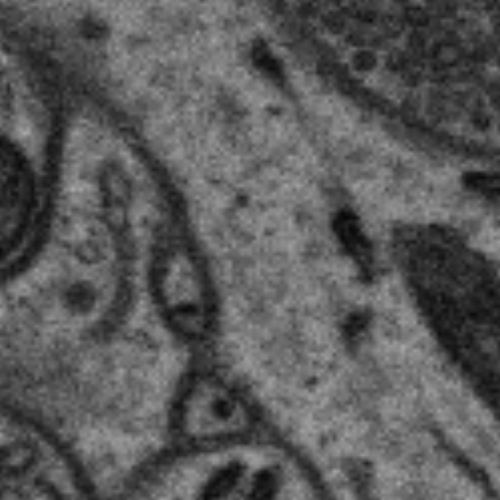

In [30]:
ex_img[0]

In [35]:
img = utils.load_img("test_inference.tif")

In [28]:
pred = learn.predict(ex_img[0])

In [31]:
pred[0].save("test_inference.tif")

In [42]:
ex_img_name.stem

'realword_SEM_test_lr_05'

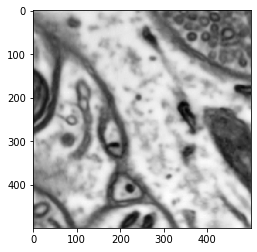

In [39]:
plt.imshow(np.squeeze(img), cmap=plt.cm.gray)